# 为啥训练到一定次数，ratio会变成nan？
# 为什么pi_prob(a)是(32,1)
# 而我的pi_prob(a)却是(32,32)
# 我没有理解源码在建立actor网络的时候是怎么建立的，因为不需要构造模型，所以它出来pi不是32个state对应一个策略

# 我知道问题出在哪了，因为之前的tfp和tensorflow是一体的，可以构造输出就是tfp的分布的模型
# 而现在分开了，tfp的分布不属于一个op，所以没有办法放到模型里

# 为什么mu，sigma我们俩的程序都是(32,1),但是莫凡的只输出了1个pi，我却输出了32个。
# 也就是说，莫凡是输入了32个s，产生了32个mu，32个sigma，但是只产生了1个pi
# 而我产生了32个mu，32个sigma，但是产生了32个pi，正因为如此，之后给了32个a，每个pi都产生了prob，所以prob形状是(32,32)，ratio自然也是(32,32),但是ratio要乘(32,1)的adv，所以出错了！

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import gym
import tensorflow_probability as tfp

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [2]:
EP_MAX = 300
EP_LEN = 300
GAMMA = 0.9
A_LR = 0.0001
C_LR = 0.0002
BATCH = 32
A_UPDATE_STEPS = 10
C_UPDATE_STEPS = 10
S_DIM, A_DIM = 3, 1   #举杆子的游戏就是这么个维度
METHOD = [
    dict(name='kl_pen', kl_target=0.01, lam=0.5),  #更新时候控制old和new参数近似的第一种方法KL
    dict(name='clip', epsilon=0.2)                 #更新时的第二种方法CLIP
][0]


In [3]:
METHOD

{'name': 'kl_pen', 'kl_target': 0.01, 'lam': 0.5}

In [4]:
class PPO():
    def __init__(self):
        self.build_actor()  #创建actor,只创建一个actor，用的时候先后顺序用
        self.build_critic() #创建critic

    
    def build_actor(self):
        '''建立网络的结构，actor'''
        # actor_new---------------------------------------------
        s = tf.keras.layers.Input(shape=(S_DIM,))
        l1 = tf.keras.layers.Dense(100, activation='relu',name='l1')(s)
        mu = tf.keras.layers.Dense(A_DIM, activation='tanh',name='mu')(l1)
        sigma = tf.keras.layers.Dense(A_DIM, activation='softplus',name='sigma')(l1)
        
        self.actor_new = tf.keras.Model(inputs=s, outputs=[mu,sigma])
        self.a_optimizer = tf.keras.optimizers.Adam(A_LR)
        
        # actor_old-------------------------------------------------
        s_1 = tf.keras.layers.Input(shape=(S_DIM,))
        l1_1 = tf.keras.layers.Dense(100, activation='relu',name='l1')(s_1)
        mu_1 = tf.keras.layers.Dense(A_DIM, activation='tanh',name='mu')(l1_1)
        sigma_1 = tf.keras.layers.Dense(A_DIM, activation='softplus',name='sigma')(l1_1)
        
        self.actor_old = tf.keras.Model(inputs=s_1, outputs=[mu_1,sigma_1])
    
    def build_critic(self): 
        '''建立网络的结构，critic'''
        # critic
        s_c = tf.keras.layers.Input(shape=(S_DIM,))
        l1_c = tf.keras.layers.Dense(100, activation='relu')(s_c)
        v = tf.keras.layers.Dense(1)(l1_c)
        
        self.critic = tf.keras.Model(inputs=s_c, outputs=v)
        self.c_optimizer = tf.keras.optimizers.Adam(C_LR)
        
    def update_new_old_actor(self):
        '''更新老actor参数'''
        #使用set_weights和get_weights的方法对每层的权重进行复制转移
        #--------------------actor的两个网络的迁移--------------------------------
        self.actor_old.set_weights(self.actor_new.get_weights())
        
    def learn(self, s, a, r):
        '''学习，输入的是batch的s，会产生batch个normdist，对于batch的a，会产生batch*batch的proba'''      
        # 旧网络产生的策略,不需要训练
        [mu1, sigma1] = self.actor_old(s, training=False)
        mu1 *= 2 #为了使-1,1到-2,2内部
        
        #不要squeeze，直接生成dis
        pi_old = tfp.distributions.Normal(mu1, sigma1)  # pi_old是old网络的策略,一共有1个形状为[32,1]
        
        #每次学习更新一下新旧网络，
        self.update_new_old_actor()
        
        #训练
        with tf.GradientTape(persistent=True) as a_tap, tf.GradientTape(persistent=True) as c_tap:
            # 新网络产生的策略
            # 注意，网络产生的值一定要放在Gradient下面，不然没有梯度
            [mu, sigma] = self.actor_new(s)
            mu *= 2
            
            #不要squeeze
            pi = tfp.distributions.Normal(mu, sigma)  # pi是现在的策略，[32,1]
                    
            #计算loss
            v = self.critic(s) #计算s的价值
            adv = r - v        #计算增益,形状是(32,1)

            
#             ratio = tf.exp(pi.log_prob(a) - pi_old.log_prob(a))
            ratio = pi.prob(a) / pi_old.prob(a)    #ratio的shape应该是(32,1)!!!!!  ,这回肯定是了！
#             print('ratio',ratio.shape)
            
            surr = ratio * adv
            
            # a的loss计算-------------------------------------------------------------------------------------------------
            # a_loss的算法因为两种方法而不同
            if METHOD['name'] == 'kl_pen':   # kl方法
                lamda = METHOD['lam']
                kl = tfp.distributions.kl_divergence(pi_old, pi)  #计算两个策略之间的KL散度
                kl_mean = tf.reduce_mean(kl)
                a_loss = -(tf.reduce_mean(surr - lamda * kl))
                
            else:                            # clip方法
                a_loss = - tf.reduce_mean(tf.minimum(
                    surr,
                    tf.clip_by_value(ratio, 1.-METHOD['epsilon'], 1.+METHOD['epsilon'])*adv))
                
                
            # c的loss计算--------------------------------------------------------------------------------------------------
            c_loss = tf.reduce_mean(tf.square(adv))
                    
        # 更新actor----------------------------------------------------------------------------------------------------------
        
        if METHOD['name'] == 'kl_pen':    #kl方法对应着kl的更新方式
            for _ in range(A_UPDATE_STEPS): #给actor更新10次 ,grads在一个循环里面只能调用一次，所以，不能这么写，除非加上persistent
                grads_a = a_tap.gradient(a_loss, self.actor_new.trainable_variables)
                self.a_optimizer.apply_gradients(zip(grads_a, self.actor_new.trainable_variables))
                # 设置内部终止条件
                kl_now = kl_mean
                if kl_now >4 * METHOD['kl_target']:
                    break
            if kl_now < METHOD['kl_target']/1.5:
                METHOD['lam'] /= 2
            elif kl_now > METHOD['kl_target']*1.5:
                METHOD['lam'] *= 2
            METHOD['lam'] = np.clip(METHOD['lam'], 1e-4, 10)
        
        else:                            #clip方法对应clip更新方式
            for _ in range(A_UPDATE_STEPS): # 就是简单地用clip方式计算的loss给a更新10次
                grads_a = a_tap.gradient(a_loss, self.actor_new.trainable_variables)
                self.a_optimizer.apply_gradients(zip(grads_a, self.actor_new.trainable_variables))
                
        # 更新critic------------------------------------------------------------------------------------------------------------
        for _ in range(C_UPDATE_STEPS):
            grads_c = c_tap.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(zip(grads_c, self.critic.trainable_variables)) 
        
    def choose_action(self, s):
        '''choose_action的时候就进来了一个s，所以只会产生一个normdist，也只会sample出来一个a'''
        s = np.expand_dims(s, axis=0)
        [mu, sigma] = self.actor_new(s, training=False)
#         mu = tf.squeeze(mu*2)
#         sigma = tf.squeeze(sigma)
        mu *= 2
        # 不要squeeze，这回就对了，输出形状是[1,1]只取第一维，得到[xx],对应着step！
        #创建一个正态分布
        normal_dist = tfp.distributions.Normal(mu, sigma)
        act_choosed = tf.clip_by_value(normal_dist.sample(1)[0][0], -2,2)  
        act_choosed = act_choosed.numpy()
        return act_choosed
    
    def get_v(self, s):
        if s.ndim < 2:
            s = np.expand_dims(s, axis=0)
        v = self.critic(s)
        return v[0][0]
        

In [5]:
ppo = PPO()

In [6]:
env = gym.make('Pendulum-v0')
all_ep_r = []

EP: 0 |ep_r: -2787 |Lam: 0.0020
EP: 1 |ep_r: -2745 |Lam: 0.0001
EP: 2 |ep_r: -2736 |Lam: 0.0001
EP: 3 |ep_r: -2752 |Lam: 0.0001
EP: 4 |ep_r: -2636 |Lam: 0.0001
EP: 5 |ep_r: -2492 |Lam: 0.0001
EP: 6 |ep_r: -2502 |Lam: 0.0001
EP: 7 |ep_r: -2327 |Lam: 0.0001
EP: 8 |ep_r: -2318 |Lam: 0.0001
EP: 9 |ep_r: -2232 |Lam: 0.0001
EP: 10 |ep_r: -2349 |Lam: 0.0001
EP: 11 |ep_r: -1492 |Lam: 0.0002
EP: 12 |ep_r: -1840 |Lam: 0.0001
EP: 13 |ep_r: -2239 |Lam: 0.0001
EP: 14 |ep_r: -2114 |Lam: 0.0001
EP: 15 |ep_r: -2021 |Lam: 0.0001
EP: 16 |ep_r: -1979 |Lam: 0.0001
EP: 17 |ep_r: -2152 |Lam: 0.0001
EP: 18 |ep_r: -1966 |Lam: 0.0001
EP: 19 |ep_r: -2280 |Lam: 0.0001
EP: 20 |ep_r: -2228 |Lam: 0.0001
EP: 21 |ep_r: -2158 |Lam: 0.0001
EP: 22 |ep_r: -2229 |Lam: 0.0001
EP: 23 |ep_r: -2018 |Lam: 0.0001
EP: 24 |ep_r: -1825 |Lam: 0.0001
EP: 25 |ep_r: -1982 |Lam: 0.0001
EP: 26 |ep_r: -1854 |Lam: 0.0001
EP: 27 |ep_r: -2290 |Lam: 0.0001
EP: 28 |ep_r: -1854 |Lam: 0.0001
EP: 29 |ep_r: -1943 |Lam: 0.0001
EP: 30 |ep_r: -1773 

EP: 245 |ep_r: -1053 |Lam: 0.0001
EP: 246 |ep_r: -923 |Lam: 0.0001
EP: 247 |ep_r: -647 |Lam: 0.0001
EP: 248 |ep_r: -645 |Lam: 0.0001
EP: 249 |ep_r: -856 |Lam: 0.0001
EP: 250 |ep_r: -649 |Lam: 0.0001
EP: 251 |ep_r: -894 |Lam: 0.0001
EP: 252 |ep_r: -2019 |Lam: 0.0001
EP: 253 |ep_r: -1748 |Lam: 0.0001
EP: 254 |ep_r: -916 |Lam: 0.0001
EP: 255 |ep_r: -648 |Lam: 0.0001
EP: 256 |ep_r: -2317 |Lam: 0.0001
EP: 257 |ep_r: -900 |Lam: 0.0001
EP: 258 |ep_r: -651 |Lam: 0.0001
EP: 259 |ep_r: -1384 |Lam: 0.0001
EP: 260 |ep_r: -1080 |Lam: 0.0008
EP: 261 |ep_r: -790 |Lam: 0.0001
EP: 262 |ep_r: -542 |Lam: 0.0001
EP: 263 |ep_r: -717 |Lam: 0.0001
EP: 264 |ep_r: -522 |Lam: 0.0001
EP: 265 |ep_r: -1025 |Lam: 0.0001
EP: 266 |ep_r: -1244 |Lam: 0.0001
EP: 267 |ep_r: -1327 |Lam: 0.0001
EP: 268 |ep_r: -513 |Lam: 0.0001
EP: 269 |ep_r: -2319 |Lam: 0.0001
EP: 270 |ep_r: -264 |Lam: 0.0001


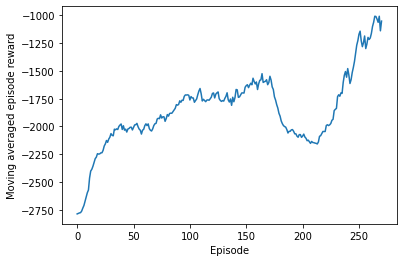

In [7]:
for ep in range(EP_MAX):
    s = env.reset()
    buffer_s, buffer_a, buffer_r = [],[],[]
    ep_r = 0
    
    for t in range(EP_LEN):
        env.render()
        a = ppo.choose_action(s)
        s_, r, done, info = env.step(a)
        buffer_s.append(s)
        buffer_a.append(a)
        buffer_r.append((r+8)/8)
        s = s_
        ep_r += r
        
        if (t+1)%BATCH==0 or t==EP_LEN-1:
            v_s_ = ppo.get_v(s_)
            discounted_r = []
            for r in buffer_r[::-1]:
                v_s_ = r + GAMMA * v_s_
                discounted_r.append(v_s_)
            discounted_r.reverse()
            
            bs, ba, br = np.vstack(buffer_s), np.vstack(buffer_a), np.expand_dims(np.array(discounted_r), axis=1)
            
            #清空三个buffer
            buffer_s, buffer_a, buffer_r = [], [], []
            
            #学习
            ppo.learn(bs, ba, br)
            
    # 用来显示奖励值
    if ep == 0: all_ep_r.append(ep_r)
    else: all_ep_r.append(all_ep_r[-1]*0.9 + ep_r*0.1)
    
    print('EP: %i'%ep,
          '|ep_r: %i'%ep_r,
          ("|Lam: %.4f" % METHOD['lam']) if METHOD['name'] == 'kl_pen' else '',
          )
    
    if ep_r > -300:
        break
# 画图
plt.plot(np.arange(len(all_ep_r)), all_ep_r)
plt.xlabel('Episode');plt.ylabel('Moving averaged episode reward');plt.show()
ppo.actor_new.save_weights('pp01_actor_weights.h5')
            

# 测试网络

In [8]:
ppo_test = PPO()

In [9]:
ppo_test.actor_new.load_weights('pp01_actor_weights.h5')

In [10]:
for ep in range(EP_MAX):
    s = env.reset()
    
    for t in range(EP_LEN):
        env.render()
        a = ppo_test.choose_action(s)
        s_, r, done, info = env.step(a)
        s = s_

            

KeyboardInterrupt: 

# 如何提取出全部的权重并且对权重进行运算，再赋值
# 也就是软更新

In [ ]:
i = tf.keras.layers.Input(shape=(1,))
x = tf.keras.layers.Dense(5)(i)
x = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inputs=i, outputs=x)

In [ ]:
w = model.get_weights()
print(w)

In [ ]:
w_new = [w1*0.1 for w1 in w]
print(w_new)

In [ ]:
[w1+w2 for w1,w2 in zip(w,w_new)]

# 在建立网络的时候直接产生pi


In [3]:
distnorm = tfp.distributions.Normal(0,1)
dsitnorm2 = tfp.distributions.Normal([0,1],[2,3])

In [4]:
print(dsitnorm2)
print(distnorm)

tfp.distributions.Normal("Normal", batch_shape=[2], event_shape=[], dtype=float32)
tfp.distributions.Normal("Normal", batch_shape=[], event_shape=[], dtype=float32)


In [45]:
s = env.reset()
buffer_s, buffer_a, buffer_r = [],[],[]
a = ppo.choose_action(s)
print(a)
for t in range(8):
    ep_r = 0
    a = ppo.choose_action(s)
    s_, r, done, info = env.step(a)
    buffer_s.append(s)
    buffer_a.append(a)
    buffer_r.append((r+8)/8)
    s = s_
    ep_r += r
bs, ba, br = np.vstack(buffer_s), np.vstack(buffer_a), np.vstack(buffer_r)


[-0.16165093]


In [46]:
bs

array([[ 0.05042878,  0.99872766,  0.66738899],
       [-0.01850657,  0.99982874,  1.37915609],
       [-0.12991862,  0.99152466,  2.23558554],
       [-0.2813611 ,  0.95960196,  3.09850634],
       [-0.45734555,  0.88928907,  3.79591537],
       [-0.6434293 ,  0.76550554,  4.47923348],
       [-0.81341724,  0.58168066,  5.02066649],
       [-0.9401022 ,  0.34089274,  5.4585398 ]])

In [47]:
ba

array([[-0.24852428],
       [ 0.7103859 ],
       [ 0.79518205],
       [-0.14861628],
       [ 0.10900874],
       [-0.21797436],
       [ 0.01075213],
       [-0.09659199]], dtype=float32)

In [48]:
br

array([[ 0.70549313],
       [ 0.66042514],
       [ 0.57573741],
       [ 0.44939201],
       [ 0.29672194],
       [ 0.1052202 ],
       [-0.10939231],
       [-0.34806021]])

In [49]:
[mu, sigma] = ppo.actor_new(bs)
print(mu)
print(sigma)

tf.Tensor(
[[ 0.05236873]
 [ 0.02980565]
 [ 0.00520472]
 [-0.03456562]
 [-0.05436929]
 [-0.06107465]
 [-0.06565797]
 [-0.079589  ]], shape=(8, 1), dtype=float32)
tf.Tensor(
[[0.5669595 ]
 [0.50955284]
 [0.45010132]
 [0.40226656]
 [0.37392932]
 [0.3539104 ]
 [0.34493133]
 [0.3466064 ]], shape=(8, 1), dtype=float32)


In [50]:
dist = tfp.distributions.Normal(mu,sigma)
print(dist)

tfp.distributions.Normal("Normal", batch_shape=[8, 1], event_shape=[], dtype=float32)


In [51]:
dist.prob(ba)

<tf.Tensor: shape=(8, 1), dtype=float32, numpy=
array([[0.6112193 ],
       [0.3208804 ],
       [0.18997525],
       [0.9526669 ],
       [0.9697659 ],
       [1.0217344 ],
       [1.1285518 ],
       [1.1496111 ]], dtype=float32)>

In [52]:
s_in_choose = env.reset()
s_in_choose = np.expand_dims(s_in_choose, axis=0)
mu_choose,sigma_choose = ppo.actor_new(s_in_choose)


In [53]:
dist_choose = tfp.distributions.Normal(mu_choose, sigma_choose)
print(dist_choose)

tfp.distributions.Normal("Normal", batch_shape=[1, 1], event_shape=[], dtype=float32)


In [54]:
a = dist_choose.sample(1)[0][0]

In [55]:
env.step(a)

(array([ 0.61060979,  0.79193162, -0.06393755]),
 -0.8798268224680682,
 False,
 {})